#  Modelo predictivo aplicando el algoritmo Random Forest para resolver un problema de clasificación utilizando lenguaje Python

Para identificar anomalías
Resumen estadístico, o dicho de
Análisis descriptivo de sus datos.

In [16]:
#librerias base
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,median_absolute_error,r2_score 
#metricas de evaluacion
import matplotlib.pyplot as plt
#librerias
import warnings
warnings.filterwarnings("ignore")

archivo = pd.read_csv("temperaturas.csv")
df = pd.DataFrame(archivo)

print('Dimensiones del df:', df.shape)

# Vamos a sacar informacion sobre los tipos y nulos del df
df.drop_duplicates(inplace = True)
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'tipo de la columna'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'campos nulos (cant)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'campos nulos (%)'}))
display(tab_info)
#__________________
#
display(df[:5])
print(df.describe())
print(df.info())


         year       month         day      temp_2      temp_1     average  \
count   348.0  348.000000  348.000000  348.000000  348.000000  348.000000   
mean   2016.0    6.477011   15.514368   62.652299   62.701149   59.760632   
std       0.0    3.498380    8.772982   12.165398   12.120542   10.527306   
min    2016.0    1.000000    1.000000   35.000000   35.000000   45.100000   
25%    2016.0    3.000000    8.000000   54.000000   54.000000   49.975000   
50%    2016.0    6.000000   15.000000   62.500000   62.500000   58.200000   
75%    2016.0   10.000000   23.000000   71.000000   71.000000   69.025000   
max    2016.0   12.000000   31.000000  117.000000  117.000000   77.400000   

           actual  forecast_noaa  forecast_acc  forecast_under      friend  
count  348.000000     348.000000    348.000000      348.000000  348.000000  
mean    62.543103      57.238506     62.373563       59.772989   60.034483  
std     11.794146      10.605746     10.549381       10.705256   15.626179 

Análisis gráfico de las temperaturas máximas históricas

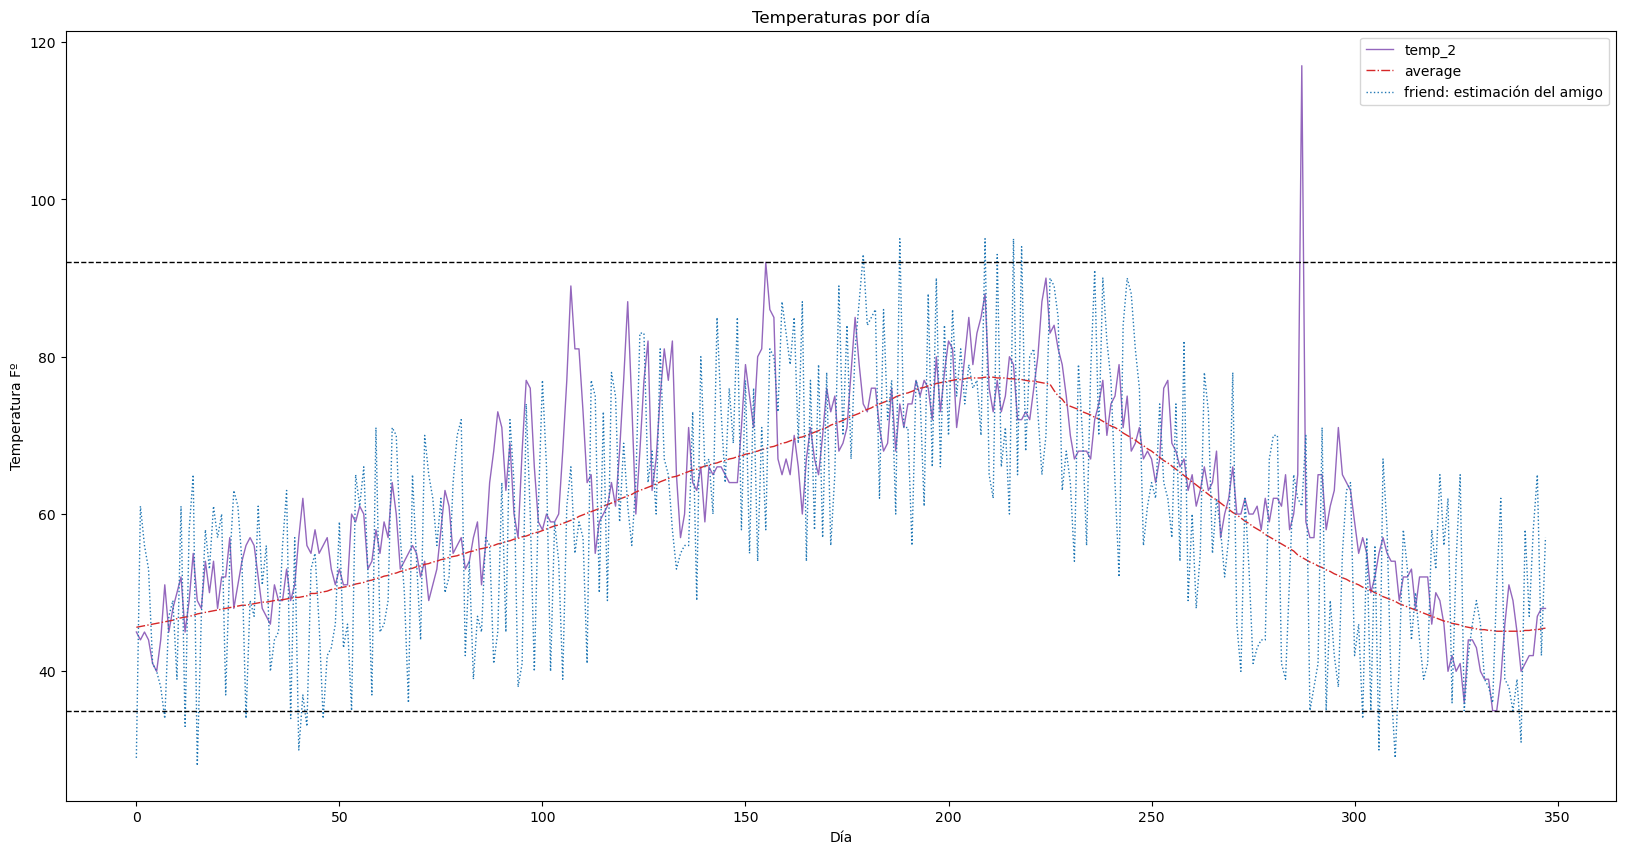

In [2]:
# Crear figura y ejes
fig, ax = plt.subplots(figsize=(20, 10))

# Graficar variables en función de los días
ax.plot(df['temp_2'], color='tab:purple', label='temp_2', linestyle="solid", linewidth=1)
# ax.plot(df['temp_1'], color='tab:green' , label='temp_1', linestyle="dashed", linewidth=1)
ax.plot(df['average'], color='tab:red'   , label='average', linestyle="dashdot", linewidth=1)
ax.plot(df['friend'], color='tab:blue'  , label='friend: estimación del amigo', linestyle="dotted", linewidth=1)
# Agregar una línea recta en el valor de 35 minima historia de la variable actual
ax.axhline(df['actual'].min(), color='black', linestyle='--', linewidth=1)

# Agregar una línea recta en el valor de 92 maxima historia de la variable actual
ax.axhline(df['actual'].max(), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Día')
ax.set_ylabel('Temperatura Fº')
ax.set_title('Temperaturas por día')
ax.legend()

plt.show()

Recodificacion de los días de la semana, creando siete variables 1-0 asociados
a los días de la semana. Le puede facilitar el proceso usando
get_dummies de la librería Pandas.

In [7]:
# Codificar columna 'week' en variables binarias
dummy_df = pd.get_dummies(df['week'])

# Renombrar las columnas con un prefijo 'week_'
dummy_df = dummy_df.add_prefix('week_')
# Concatenar el DataFrame original con el DataFrame codificado
df = pd.concat([df, dummy_df], axis=1)
#Eliminar columna week ya codificada
df = df.drop('week', axis=1)

# Mostrar el DataFrame resultante
df 


,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,...,week_Thurs,week_Tues,week_Wed,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,43,50,44,...,0,0,0,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,41,50,44,...,0,0,0,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,43,46,47,...,0,0,0,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,44,48,46,...,0,0,0,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,46,46,46,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,42,42,45.2,47,41,50,47,...,0,1,0,0,0,0,0,0,1,0
344,2016,12,28,42,47,45.3,48,41,49,44,...,0,0,1,0,0,0,0,0,0,1
345,2016,12,29,47,48,45.3,48,43,50,45,...,1,0,0,0,0,0,0,1,0,0
346,2016,12,30,48,48,45.4,57,44,46,44,...,0,0,0,1,0,0,0,0,0,0


4. Ahora, separe los datos en predictores y variable respuesta. Su variable
Y es la temperatura máxima real y los predictores son todas las
columnas que usa el modelo para hacer una predicción. Asegúrese de
transformar en una matriz Numpy porque esa es la forma en que
funciona el algoritmo.
5. Separe su base en entrenamiento y testeo en 75/25. Use una semilla
(random_state = 42) para obtener los mismos valores.

In [24]:
X = df.drop(['actual','forecast_noaa','forecast_acc','forecast_under','week'], axis=1)
y = df['actual']

X_train, X_test, y_train, y_test = train_test_split(X , y ,test_size= 0.25 ,random_state= 42 )


Ajuste un modelo de regresión de bosque aleatorio con los datos de entrenamiento.
Implemente 1000 árboles y use la misma semilla declarada en el punto 5.

In [25]:
# Create a Random Forest classifier
rf = RandomForestClassifier(
    n_estimators=1000,
    random_state=42
)
# Train the classifier
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

Obtenga la predicción.


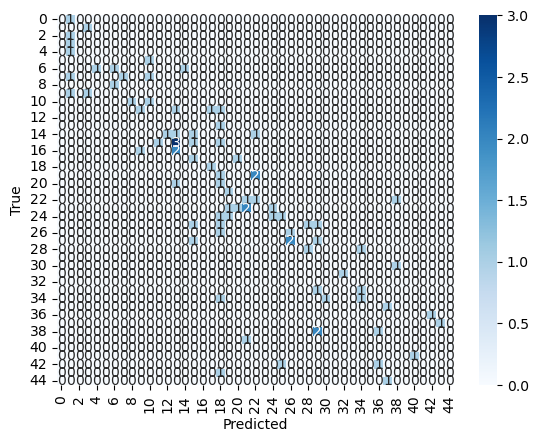

In [26]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

Métricas de precisión.


In [34]:
print("MSE:", mean_squared_error(y_test,rf.predict(X_test)))
print("MAE:",median_absolute_error(y_test,rf.predict(X_test)))
print("R2:", r2_score(y_test, rf.predict(X_test)))
# Calculamos manualmente el R Cuadrado ajustado
c = 1 - (1-rf.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
print("R2 ajustado:", c)

MSE: 45.195402298850574
MAE: 3.0
R2: 0.6750141552632878
R2 ajustado: 0.7712474645030426


El modelo concentra una variabilidad del 67.5% de los datos lo cual es aceptable por ser maypor del 50% admas el R2 ajustado aumenta este porcentaje a 77.1% amplia la concentracion de variabilidad de los datos.
Con un MAE de 3.0 podemos visualizar que entre la temperatura real y la predicha hay 3 grados de diferencia lo que es relativamente pequeño.
